In [102]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Step 1:  Data generation

In [103]:
import numpy as np
from numpy.random import seed
seed(1)
import pyfftw
import matplotlib.pyplot as plt 
import time as tm
import os

In [104]:
font = {'family' : 'Times New Roman',
        'size'   : 14}    
plt.rc('font', **font)

if not os.path.exists("snapshots"):
    os.makedirs("./snapshots")

# Fast Poisson solver using second-order central difference scheme

$$\nabla^{2}\psi=-\omega$$

In [105]:
def fps(nx, ny, dx, dy, f):
    epsilon = 1.0e-6
    aa = -2.0/(dx*dx) - 2.0/(dy*dy)
    bb = 2.0/(dx*dx)
    cc = 2.0/(dy*dy)
    hx = 2.0*np.pi/np.float64(nx)
    hy = 2.0*np.pi/np.float64(ny)
    
    kx = np.empty(nx)
    ky = np.empty(ny)
    
    kx[:] = hx*np.float64(np.arange(0, nx))

    ky[:] = hy*np.float64(np.arange(0, ny))
    
    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(np.cos(kx), np.cos(ky), indexing='ij')
    
    data = np.empty((nx,ny), dtype='complex128')
    data1 = np.empty((nx,ny), dtype='complex128')
    
    data[:,:] = np.vectorize(complex)(f[1:nx+1,1:ny+1],0.0)

    a = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    b = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    
    fft_object = pyfftw.FFTW(a, b, axes = (0,1), direction = 'FFTW_FORWARD')
    fft_object_inv = pyfftw.FFTW(a, b,axes = (0,1), direction = 'FFTW_BACKWARD')
    
    e = fft_object(data)
    #e = pyfftw.interfaces.scipy_fftpack.fft2(data)
    
    e[0,0] = 0.0
    
    data1[:,:] = e[:,:]/(aa + bb*kx[:,:] + cc*ky[:,:])

    ut = np.real(fft_object_inv(data1))
    
    #periodicity
    u = np.empty((nx+3,ny+3)) 
    u[1:nx+1,1:ny+1] = ut
    u[:,ny+1] = u[:,1]
    u[nx+1,:] = u[1,:]
    u[nx+1,ny+1] = u[1,1]
    return u

# Set periodic boundary condition for ghost nodes. Index 0 and (n+2) are the ghost boundary locations

In [106]:
def bc(nx,ny,u):
    u[:,0] = u[:,ny]
    u[:,ny+2] = u[:,2]
    
    u[0,:] = u[nx,:]
    u[nx+2,:] = u[2,:]
    
    return u  

# Compute rhs using Arakawa scheme

We do all the computations in full order space for the physics-based modeling. The spatial discretization of the partial differential equations (PDEs) given by the following equation leads to a system of coupled ordinary differential equations (ODEs) in the following simplified form:

$$\frac{d\omega_{i,j}}{dt} = R_{i,j}$$

where $R$ denotes the discrete of spatial derivative operator including the non-linear convective terms and the linear diffusive terms. We use the finite difference approximation to discretize the equation as

$$ \omega_{i,j}^{n+1} = \omega_{i,j}^{n} + \Delta t R_{i,j}^{n}$$

Here, the right-hand-side can be expressed by $R_{i,j}^{n} = - J(\omega_{i,j}^n, \psi_{i,j}^n) + \frac{1}{Re} \nabla^2 \omega_{i,j}^{n}$ for the Euler scheme.

To avoid computational instabilities arising from non-linear interactions, we use second order skew symmetric, energy and enstrophy conserving Arakawa scheme for the non-linear Jacobian. The Jacobian defined can be expressed as

$$Jac(\omega, \psi) = \frac{1}{3}(J_1(\omega, \psi) + J_2(\omega, \psi) + J_3(\omega, \psi))$$

where: 

$$J_1(\omega, \psi) = \frac{1}{4 \Delta x \Delta y} [(\omega_{i+1,j} - \omega_{i-1,j})(\psi_{i,j+1} - \psi_{i,j-1}) - (\omega_{i,j+1} - \omega_{i,j-1})(\psi_{i+1,j} - \psi_{i-1,j})]$$
  
  $$J_2(\omega, \psi) =\frac{1}{4 \Delta x \Delta y} [\omega_{i+1,j}(\psi_{i+1,j+1} - \psi_{i+1,j-1}) - \omega_{i-1,j}(\psi_{i-1,j+1} - \psi_{i-1,j-1}) - \omega_{i,j+1}(\psi_{i+1,j+1} - \psi_{i-1,j+1}) - \omega_{i,j-1}(\psi_{i+1,j-1} - \psi_{i-1,j-1})]$$
  
  $$J_3(\omega, \psi) = \frac{1}{4 \Delta x \Delta y} [\omega_{i+1,j+1}(\psi_{i,j+1} - \psi_{i+1,j}) - \omega_{i-1,j-1}(\psi_{i-1,j} - \psi_{i,j-1}) - \omega_{i-1,j+1}(\psi_{i,j+1} - \psi_{i-1,j}) - \omega_{i+1,j-1}(\psi_{i+1,j} - \psi_{i,j-1})]$$
  


In [107]:
def rhs(nx,ny,dx,dy,re,w,s,x,y,ts):
    aa = 1.0/(dx*dx)
    bb = 1.0/(dy*dy)
    gg = 1.0/(4.0*dx*dy)
    hh = 1.0/3.0
    
    f = np.zeros((nx+3,ny+3))
    
    #Arakawa
    j1 = gg*( (w[2:nx+3,1:ny+2]-w[0:nx+1,1:ny+2])*(s[1:nx+2,2:ny+3]-s[1:nx+2,0:ny+1]) \
             -(w[1:nx+2,2:ny+3]-w[1:nx+2,0:ny+1])*(s[2:nx+3,1:ny+2]-s[0:nx+1,1:ny+2]))

    j2 = gg*( w[2:nx+3,1:ny+2]*(s[2:nx+3,2:ny+3]-s[2:nx+3,0:ny+1]) \
            - w[0:nx+1,1:ny+2]*(s[0:nx+1,2:ny+3]-s[0:nx+1,0:ny+1]) \
            - w[1:nx+2,2:ny+3]*(s[2:nx+3,2:ny+3]-s[0:nx+1,2:ny+3]) \
            + w[1:nx+2,0:ny+1]*(s[2:nx+3,0:ny+1]-s[0:nx+1,0:ny+1]))

    j3 = gg*( w[2:nx+3,2:ny+3]*(s[1:nx+2,2:ny+3]-s[2:nx+3,1:ny+2]) \
            - w[0:nx+1,0:ny+1]*(s[0:nx+1,1:ny+2]-s[1:nx+2,0:ny+1]) \
            - w[0:nx+1,2:ny+3]*(s[1:nx+2,2:ny+3]-s[0:nx+1,1:ny+2]) \
            + w[2:nx+3,0:ny+1]*(s[2:nx+3,1:ny+2]-s[1:nx+2,0:ny+1]) )

    jac = (j1+j2+j3)*hh
    
    lap = aa*(w[2:nx+3,1:ny+2]-2.0*w[1:nx+2,1:ny+2]+w[0:nx+1,1:ny+2]) \
        + bb*(w[1:nx+2,2:ny+3]-2.0*w[1:nx+2,1:ny+2]+w[1:nx+2,0:ny+1])
      
    source = -0.01*np.cos(3*x)*np.cos(3*y)*np.exp(-ts/(re))
#Try out the see the effect of turning off the source term 
    f[1:nx+2,1:ny+2] = -jac + lap/re +source
                        
    return f

# Set initial condition for vortex merger problem

In [108]:
def vm_ic(nx,ny,x,y):
    w = np.empty((nx+3,ny+3))
    sigma = np.pi
    xc1 = np.pi-np.pi/4.0
    yc1 = np.pi
    xc2 = np.pi+np.pi/4.0
    yc2 = np.pi
    # Initial conditions can be modified
    w[1:nx+2, 1:ny+2] = np.exp(-sigma*((x[0:nx+1, 0:ny+1]-xc1)**2 + (y[0:nx+1, 0:ny+1]-yc1)**2)) + np.exp(-sigma*((x[0:nx+1, 0:ny+1]-xc2)**2 + (y[0:nx+1, 0:ny+1]-yc2)**2))
    w = bc(nx,ny,w)
    return w

# Read input

In [109]:
nd = np.int64(256)      # resolution
nt = np.int64(2000)     # No. of timesteps
re = np.float64(600.0)  # Reynolds Number = Run for different Reynolds numbers=100, 200,400,500,800,1000
dt = np.float64(0.01)   # time step
ns = np.int64(200)      # no. of files to store
isolver = np.int64(1)   # ikeda (1), arakawa (2)
isc = np.int64(1)       # (0) dont write on screen (1) write on screen
ich = np.int64(19)      # check for the file
ipr = np.int64(2)       # (1)TGV, (2)VM, (3)Decay

In [110]:
freq = int(nt/ns)
nx = nd
ny = nd

In [111]:
pi = np.pi
lx = 2.0*pi
ly = 2.0*pi

dx = lx/np.float64(nx)
dy = ly/np.float64(ny)

ifile = 0
time = 0.0

x = np.linspace(0.0,2.0*np.pi,nx+1)
y = np.linspace(0.0,2.0*np.pi,ny+1)

x, y = np.meshgrid(x, y, indexing='ij')

In [112]:
# allocate the vorticity and streamfunction arrays
w = np.empty((nx+3,ny+3)) 
s = np.empty((nx+3,ny+3))
t = np.empty((nx+3,ny+3))
r = np.empty((nx+3,ny+3))

In [113]:
w0 = vm_ic(nx,ny,x,y)
    
w = np.copy(w0)
s = fps(nx, ny, dx, dy, -w)
s = bc(nx,ny,s)

os.makedirs("./snapshots/Re_" + str(int(re))+"/w")
os.makedirs("./snapshots/Re_" + str(int(re))+"/s")

filename = "./snapshots/Re_" + str(int(re))+"/w/w_0.csv"
np.savetxt(filename, w, delimiter=",")
filename = "./snapshots/Re_" + str(int(re))+"/s/s_0.csv"
np.savetxt(filename, s, delimiter=",")

$$\nabla^2 \psi^{(n)} = -\omega^{(n)} $$

$$R^{(n)} = - J(\omega^{(n)},\psi^{(n)}) + \frac{1}{Re} \nabla^2 \omega^{(n)} $$

$$\omega^{(1)} = \omega^{(n)} + \Delta t R^{(n)}$$

$$\nabla^2 \psi^{(1)} = - \omega^{(1)} $$

$$R^{(1)} = - J(\omega^{(1)},\psi^{(1)}) + \frac{1}{Re} \nabla^2 \omega^{(1)}$$

$$\omega^{(2)} = \frac{3}{4}\omega^{(n)} + \frac{1}{4} \omega^{(1)} + \frac{1}{4} \Delta t R^{(1)} $$

$$\nabla^2 \psi^{(2)} = - \omega^{(2)} R^{(2)} = - J(\omega^{(2)},\psi^{(2)}) + \frac{1}{Re} \nabla^2 \omega^{(2)} $$

$$\omega^{(n+1)} = \frac{1}{3}\omega^{(n)} + \frac{2}{3} \omega^{(2)} + \frac{2}{3} \Delta t R^{(2)} $$

In [114]:
# time integration using third-order Runge Kutta method
aa = 1.0/3.0
bb = 2.0/3.0
clock_time_init = tm.time()
for k in range(1,nt+1):
    time = time + dt
    r = rhs(nx,ny,dx,dy,re,w,s,x,y,time)
    
    #stage-1
    t[1:nx+2,1:ny+2] = w[1:nx+2,1:ny+2] + dt*r[1:nx+2,1:ny+2]
    
    t = bc(nx,ny,t)
    
    s = fps(nx, ny, dx, dy, -t)
    s = bc(nx,ny,s)
    
    r = rhs(nx,ny,dx,dy,re,t,s,x,y,time)
    
    #stage-2
    t[1:nx+2,1:ny+2] = 0.75*w[1:nx+2,1:ny+2] + 0.25*t[1:nx+2,1:ny+2] + 0.25*dt*r[1:nx+2,1:ny+2]
    
    t = bc(nx,ny,t)
    
    s = fps(nx, ny, dx, dy, -t)
    s = bc(nx,ny,s)
    
    r = rhs(nx,ny,dx,dy,re,t,s,x,y,time)
    
    #stage-3
    w[1:nx+2,1:ny+2] = aa*w[1:nx+2,1:ny+2] + bb*t[1:nx+2,1:ny+2] + bb*dt*r[1:nx+2,1:ny+2]
    
    w = bc(nx,ny,w)
    
    s = fps(nx, ny, dx, dy, -w)
    s = bc(nx,ny,s)
    
    if (k%freq == 0):
        filename = "./snapshots/Re_" + str(int(re))+"/w/w_"+str(int(k/freq))+".csv"
        np.savetxt(filename, w, delimiter=",")
        filename = "./snapshots/Re_" + str(int(re))+"/s/s_"+str(int(k/freq))+".csv"
        np.savetxt(filename, s, delimiter=",")
        
    if (k%(10*freq) == 0):
        print(k, " ", time)

total_clock_time = tm.time() - clock_time_init
print('Total clock time=', total_clock_time)

100   1.0000000000000007
200   2.0000000000000013
300   2.99999999999998
400   3.9999999999999587
500   4.999999999999938
600   5.9999999999999165
700   6.999999999999895
800   7.999999999999874
900   8.999999999999853
1000   9.999999999999831
1100   10.99999999999981
1200   11.999999999999789
1300   12.999999999999767
1400   13.999999999999746
1500   14.999999999999725
1600   15.999999999999703
1700   16.999999999999858
1800   18.000000000000014
1900   19.00000000000017
2000   20.000000000000327
Total clock time= 62.246609926223755


/var/folders/px/kfx0kpc11td_5_f5ny95_wrh0000gn/T/ipykernel_32834/848324885.py:3: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cs = axs[0].contourf(w0[1:nx+2,1:ny+2].T, 120, cmap = 'jet', interpolation='bilinear')
/var/folders/px/kfx0kpc11td_5_f5ny95_wrh0000gn/T/ipykernel_32834/848324885.py:5: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cs = axs[1].contourf(w[1:nx+2,1:ny+2].T, 120, cmap = 'jet', interpolation='bilinear')


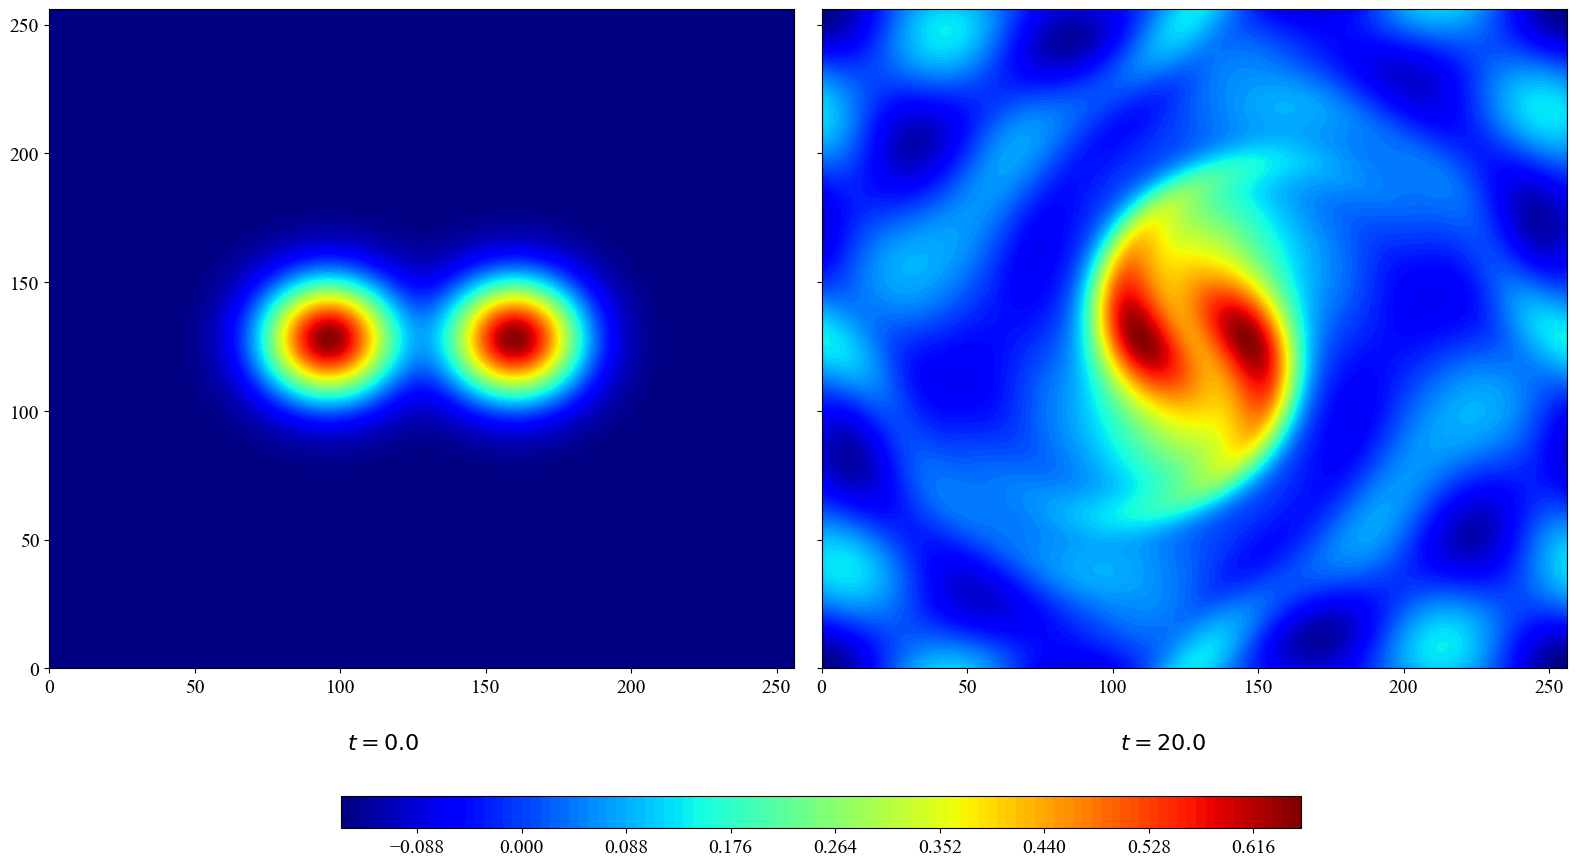

In [115]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(16,8))

cs = axs[0].contourf(w0[1:nx+2,1:ny+2].T, 120, cmap = 'jet', interpolation='bilinear')
axs[0].text(0.4, -0.1, '$t = 0.0$', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top')
cs = axs[1].contourf(w[1:nx+2,1:ny+2].T, 120, cmap = 'jet', interpolation='bilinear')
axs[1].text(0.4, -0.1, '$t = '+str(dt*nt)+'$', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top')

fig.tight_layout() 

fig.subplots_adjust(bottom=0.15)

cbar_ax = fig.add_axes([0.22, -0.05, 0.6, 0.04])
fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
plt.show()

fig.savefig("./snapshots/Re_" + str(int(re))+"/field_fdm.eps", bbox_inches = 'tight')

# To do
* Run the code for different Reynolds number Re_i=100,200,300,400,500,600,800,1000. This will result in folders snapshots/Re_i

* Also see the effect of turning off the source term ie. source=0

* Play with different initial conditions

* Use the data generated to discover the equations that generated the data 
* Discover the equation generating the data

# Reference
https://arxiv.org/pdf/1910.13909.pdf